In [1]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Load and Prepare Data

data_path = 'list_merged_no_X_no_dups.csv'
df = pd.read_csv(data_path)

display(Markdown("## Original Data Head"))
display(df.head())
# Step 2: Configuration and Mappings

vocab_size = 21  # 20 amino acids + padding
num_classes = 9  # 8 secondary structure classes + padding
max_seq_len = 512
embedding_dim = 512
dropout_rate = 0.6
l2_lambda = 0.01

# Mapping dictionaries
aa_dict = {aa: idx for idx, aa in enumerate('ACDEFGHIKLMNPQRSTVWY', 1)}
ss_dict = {
    'H': 1, 'G': 2, 'I': 3,  # Helices
    'E': 4, 'B': 5,  # Strands
    'T': 6, 'S': 7, 'C': 8   # Loops/Turns/Coils
}  # 0 reserved for padding

display(Markdown("## Mappings"))
display(Markdown(f"**Amino Acid Dictionary:** {aa_dict}"))
display(Markdown(f"**Secondary Structure Dictionary:** {ss_dict}"))

# Step 3: Data Preprocessing

def process_sequence(row):
    aa_padded = row['input'].ljust(max_seq_len, '0')[:max_seq_len]
    ss_padded = row['dssp8'].ljust(max_seq_len, '0')[:max_seq_len]  
    
    aa_encoded = [aa_dict.get(c, 0) for c in aa_padded]
    ss_encoded = [ss_dict.get(c, 0) for c in ss_padded]
    
    ss_one_hot = tf.keras.utils.to_categorical(ss_encoded, num_classes=num_classes)
    
    return aa_encoded, ss_one_hot

df['processed'] = df.apply(process_sequence, axis=1)

display(Markdown("## Data After Processing (First 5 Rows)"))
display(df[['input', 'dssp8', 'processed']].head())

# Extract sequences and labels
aa_sequences = np.array([x[0] for x in df['processed']])
ss_labels = np.array([x[1] for x in df['processed']])

display(Markdown("## Amino Acid Sequences Array (First 5 Entries)"))
display(aa_sequences[:5])
display(Markdown("## Secondary Structure Labels Array (First 5 Entries)"))
display(ss_labels[:5])
# Step 4: Train/Validation/Test Split

X_train, X_temp, y_train, y_temp = train_test_split(aa_sequences, ss_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.66, random_state=42)

display(Markdown("## Data Split Shapes"))
display(Markdown(f"**X_train shape:** {X_train.shape}"))
display(Markdown(f"**y_train shape:** {y_train.shape}"))
display(Markdown(f"**X_val shape:** {X_val.shape}"))
display(Markdown(f"**y_val shape:** {y_val.shape}"))
display(Markdown(f"**X_test shape:** {X_test.shape}"))
display(Markdown(f"**y_test shape:** {y_test.shape}"))

## Original Data Head

,pdb_id,input,dssp3,dssp8,Accessible_Surface_Area
0,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...,8284.1
1,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,CCHHHHHHHHHCCEEEEEECCCCCEEEECCEEEECCCCCCCCHHHH...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEEEESSSCIIIIHHHH...,8584.5
2,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...,8277.6
3,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTAAKSELDKAIGR...,CCHHHHHHHHHCCEEEEEECCCCCEEEECCEECCHHHHHHHHHHCC...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEECCHHHHHHHHHHTS...,8382.8
4,104L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,CCHHHHHHHHCCCCCECEECCCCCEEECCCEEEECCCCCCHHHHHH...,CCHHHHHHHHTCCCSBCEECTTSCEEETTTEEEECCTTCCHHHHHH...,15931.7


## Mappings

**Amino Acid Dictionary:** {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}

**Secondary Structure Dictionary:** {'H': 1, 'G': 2, 'I': 3, 'E': 4, 'B': 5, 'T': 6, 'S': 7, 'C': 8}

## Data After Processing (First 5 Rows)

,input,dssp8,processed
0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...,"([11, 18, 10, 16, 4, 6, 4, 19, 14, 10, 18, 10,..."
1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEEEESSSCIIIIHHHH...,"([11, 12, 8, 5, 4, 11, 10, 15, 8, 3, 4, 6, 10,..."
2,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...,"([11, 18, 10, 16, 4, 6, 4, 19, 14, 10, 18, 10,..."
3,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTAAKSELDKAIGR...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEECCHHHHHHHHHHTS...,"([11, 12, 8, 5, 4, 11, 10, 15, 8, 3, 4, 6, 10,..."
4,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,CCHHHHHHHHTCCCSBCEECTTSCEEETTTEEEECCTTCCHHHHHH...,"([11, 12, 8, 5, 4, 11, 10, 15, 8, 3, 4, 6, 10,..."


## Amino Acid Sequences Array (First 5 Entries)

array([[11, 18, 10, ...,  0,  0,  0],
       [11, 12,  8, ...,  0,  0,  0],
       [11, 18, 10, ...,  0,  0,  0],
       [11, 12,  8, ...,  0,  0,  0],
       [11, 12,  8, ...,  0,  0,  0]])

## Secondary Structure Labels Array (First 5 Entries)

array([[[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

    

## Data Split Shapes

**X_train shape:** (90050, 512)

**y_train shape:** (90050, 512, 9)

**X_val shape:** (13121, 512)

**y_val shape:** (13121, 512, 9)

**X_test shape:** (25473, 512)

**y_test shape:** (25473, 512, 9)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Step 1: Custom functions
from tensorflow.keras.callbacks import ModelCheckpoint

class LearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)
        super().on_epoch_end(epoch, logs)

def masked_accuracy(y_true, y_pred):
    y_true_class = tf.argmax(y_true, axis=-1)
    y_pred_class = tf.argmax(y_pred, axis=-1)
    mask = tf.cast(tf.not_equal(y_true_class, 0), dtype=tf.float32)
    matches = tf.cast(tf.equal(y_true_class, y_pred_class), dtype=tf.float32)
    return tf.reduce_sum(matches * mask) / tf.reduce_sum(mask)

def masked_categorical_crossentropy(y_true, y_pred):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.reduce_any(tf.not_equal(y_true, 0), axis=-1), dtype=tf.float32)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

checkpoint_callback = ModelCheckpoint(
    'best_model_kernel_5_resumed5.h5',  # same name as used previously
    monitor='val_masked_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Step 2: Load model
model = load_model("best_model_kernel_5_resumed4.h5", custom_objects={
    'masked_accuracy': masked_accuracy,
    'masked_categorical_crossentropy': masked_categorical_crossentropy
})



In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


Physical devices cannot be modified after being initialized
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


In [4]:
!nvidia-smi

Sun Apr 13 12:09:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8             14W /   95W |    5990MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Step 7: Compile the Model
# ---------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss=masked_categorical_crossentropy,
    metrics=[masked_accuracy]
)

model.summary()

callbacks = [
    checkpoint_callback,
    LearningRateTracker(),
    EarlyStopping(monitor='loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    batch_size=24,
    callbacks=callbacks,
    verbose=1
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 512)          10752     
                                                                 
 conv1d (Conv1D)             (None, 512, 512)          1311232   
                                                                 
 conv1d_1 (Conv1D)           (None, 512, 512)          1311232   
                                                                 
 conv1d_2 (Conv1D)           (None, 512, 512)          1311232   
                                                                 
 bidirectional (Bidirectiona  (None, 512, 1024)        4198400   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 1024)         0         
                                                        

KeyboardInterrupt: 

In [6]:
def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Convert one-hot encoded labels to class indices
    y_true_classes = np.argmax(y_test, axis=-1).flatten()
    y_pred_classes = np.argmax(y_pred, axis=-1).flatten()
    
    # Create mask to ignore padding (class 0)
    mask = y_true_classes != 0
    
    # Apply mask to both true and predicted labels
    y_true_masked = y_true_classes[mask]
    y_pred_masked = y_pred_classes[mask]
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_masked, y_pred_masked)
    print(f"\nTest Accuracy (excluding padding): {accuracy:.4f}")
    
    # Classification report (for 8 states: G, H, I, B, E, T, S, C)
    print("\nClassification Report:")
    print(classification_report(
        y_true_masked, 
        y_pred_masked, 
        target_names=['G', 'H', 'I', 'B', 'E', 'T', 'S', 'C'], 
        labels=[1, 2, 3, 4, 5, 6, 7, 8],
        digits=4
    ))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_masked, y_pred_masked, labels=[1, 2, 3, 4, 5, 6, 7, 8])
    
    # Plot unnormalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['G', 'H', 'I', 'B', 'E', 'T', 'S', 'C'], 
                yticklabels=['G', 'H', 'I', 'B', 'E', 'T', 'S', 'C'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (excluding padding)')
    plt.show()
    
    # Compute normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=['G', 'H', 'I', 'B', 'E', 'T', 'S', 'C'], 
                yticklabels=['G', 'H', 'I', 'B', 'E', 'T', 'S', 'C'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix (excluding padding)')
    plt.show()

797/797 [==============================] - 96s 119ms/step

Test Accuracy (excluding padding): 0.8161

Classification Report:
              precision    recall  f1-score   support

           G     0.9047    0.9304    0.9174   3244619
           H     0.6839    0.6957    0.6898    356368
           I     0.7389    0.6908    0.7140     57067
           B     0.8725    0.8968    0.8845   2152530
           E     0.8791    0.4213    0.5696    116307
           T     0.7036    0.7104    0.7070   1081024
           S     0.7859    0.5363    0.6375    869452
           C     0.7110    0.7658    0.7373   1815500

   micro avg     0.8188    0.8161    0.8174   9692867
   macro avg     0.7850    0.7059    0.7321   9692867
weighted avg     0.8188    0.8161    0.8140   9692867



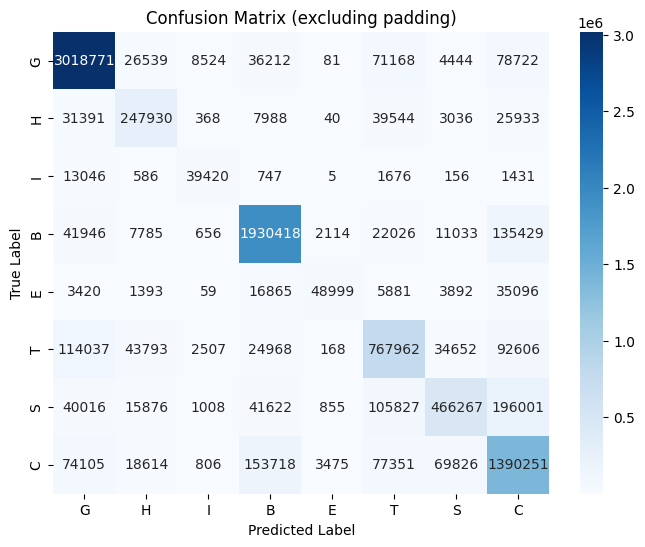

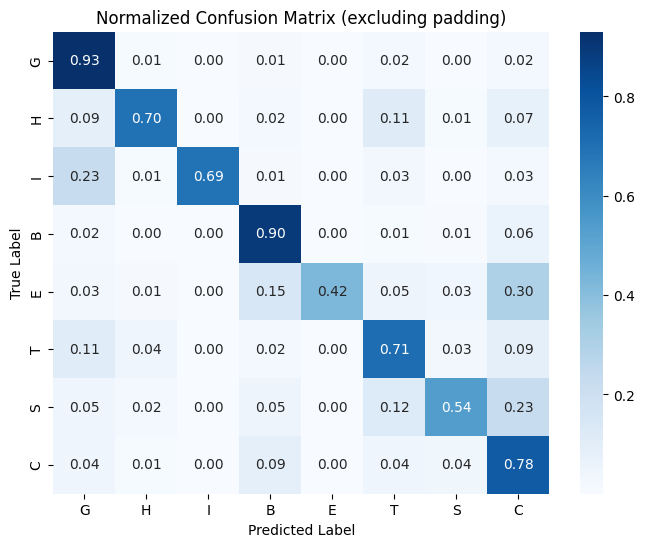

In [7]:
evaluate_model(model, X_test, y_test)
